In [31]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.src.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
import shutil

base_dir = 'Images'

train_dir = 'train'
test_dir = 'test'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(os.path.join(train_dir, 'glasses'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'no_glasses'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'glasses'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'no_glasses'), exist_ok=True)


def split_dataset(source_dir, train_dir, test_dir, split_ratio=0.8):
    for class_name in ['glasses', 'no_glasses']:
        source_class_dir = os.path.join(base_dir, class_name)
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)

        images = [
            img_name for img_name in os.listdir(source_class_dir)
            if os.path.isfile(os.path.join(source_class_dir, img_name)) and not img_name.startswith('.')
        ]
        random.shuffle(images)

        split_idx = int(len(images) * split_ratio)
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        for img_name in train_images:
            src_path = os.path.join(source_class_dir, img_name)
            dest_path = os.path.join(train_class_dir, img_name)
            shutil.copy(src_path, dest_path)

        for img_name in test_images:
            src_path = os.path.join(source_class_dir, img_name)
            dest_path = os.path.join(test_class_dir, img_name)
            shutil.copy(src_path, dest_path)

split_dataset(base_dir, train_dir, test_dir)


'''
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255)

def clean_checkpoints(directory):
    for root, dirs, _ in os.walk(directory):
        for dir_name in dirs:
            if dir_name == ".ipynb_checkpoints":
                shutil.rmtree(os.path.join(root, dir_name))
'''

'''
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)
'''

train_experiment = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=32,
)

test_experiment = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=32,
)
classnames_train = train_experiment.class_names
classnames_test = test_experiment.class_names
print(classnames_train, classnames_test)





Found 3935 files belonging to 2 classes.
Found 985 files belonging to 2 classes.
['glasses', 'no_glasses'] ['glasses', 'no_glasses']


# Data visualisation


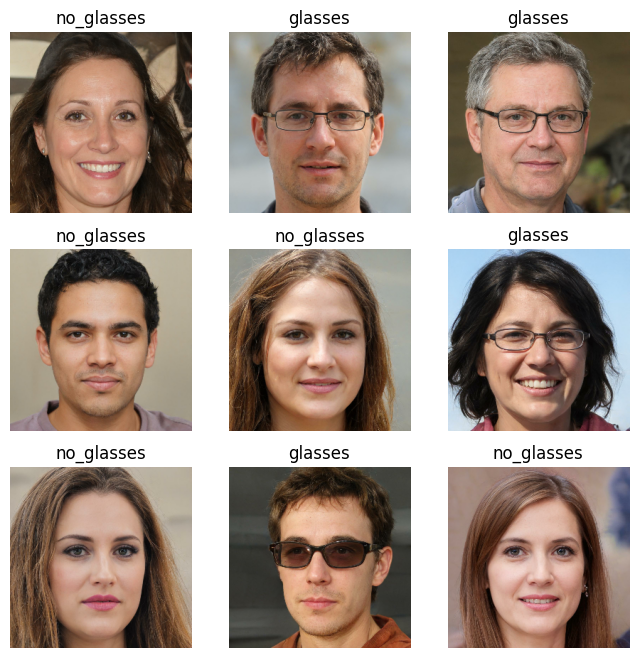

In [32]:
plt.figure(figsize=(8, 8))
for images, labels in train_experiment.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classnames_train[labels[i]])
        plt.axis("off")

# Data Optimisation

In [33]:
AUTOTUNE = tf.data.AUTOTUNE
'''
def directory_to_dataset(directory_iterator):
    dataset = tf.data.Dataset.from_generator(
        lambda: directory_iterator,
        output_signature=(
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )
    return dataset
'''
batch_size = 23
train_dataset = train_experiment.cache().shuffle(buffer_size=500).prefetch(buffer_size=2)
test_dataset = test_experiment.cache().prefetch(buffer_size=2)



In [35]:

model = Sequential([
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam",
              loss='binary_crossentropy', #tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
    #train_experiment,
    train_dataset,
    epochs=5,
    validation_data= test_dataset #test_experiment
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save("glasses_classification_model.keras")
print("Modèle sauvegardé avec succès.")


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "C:\Users\vince\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\vince\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\vince\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\vince\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Users\vince\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\vince\AppData\Local\Temp\ipykernel_12464\4098283363.py", line 22, in <module>

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 368, in fit

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 216, in function

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 129, in multi_step_on_iterator

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 110, in one_step_on_data

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 59, in train_step

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\trainers\trainer.py", line 399, in _compute_loss

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\trainers\trainer.py", line 367, in compute_loss

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\trainers\compile_utils.py", line 692, in __call__

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\trainers\compile_utils.py", line 701, in call

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\losses\losses.py", line 33, in call

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\losses\losses.py", line 2241, in sparse_categorical_crossentropy

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\ops\nn.py", line 1841, in sparse_categorical_crossentropy

  File "C:\Users\vince\PycharmProjects\ProjetDataScientist\.venv\lib\site-packages\keras\src\backend\tensorflow\nn.py", line 714, in sparse_categorical_crossentropy

Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_32566]